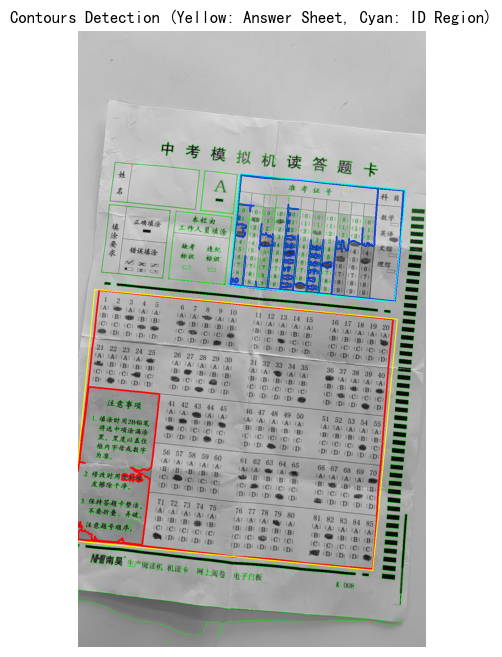

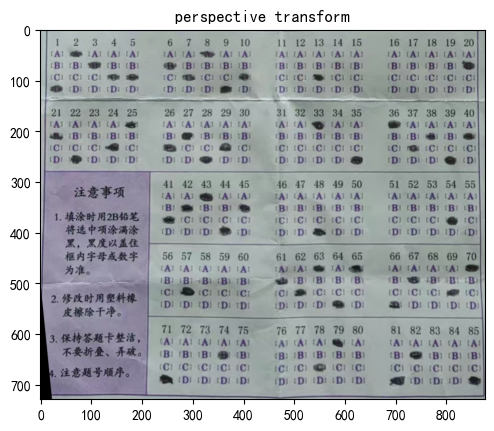

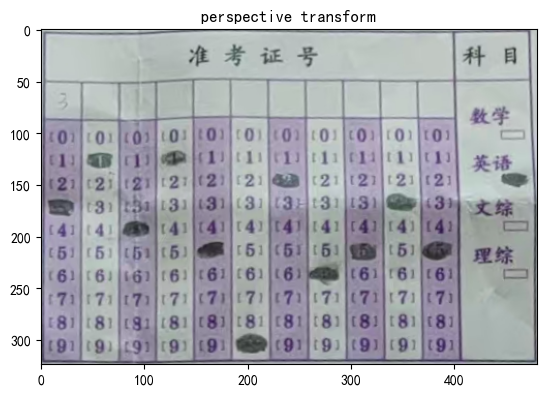

In [2]:
from find_region import process_answer_sheet
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from typing import Tuple, Optional, Dict, Any

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

image_path = 'images/test8.jpg'
_, id_raw = process_answer_sheet(image_path, show=True)

# 图像预处理

## 主程序

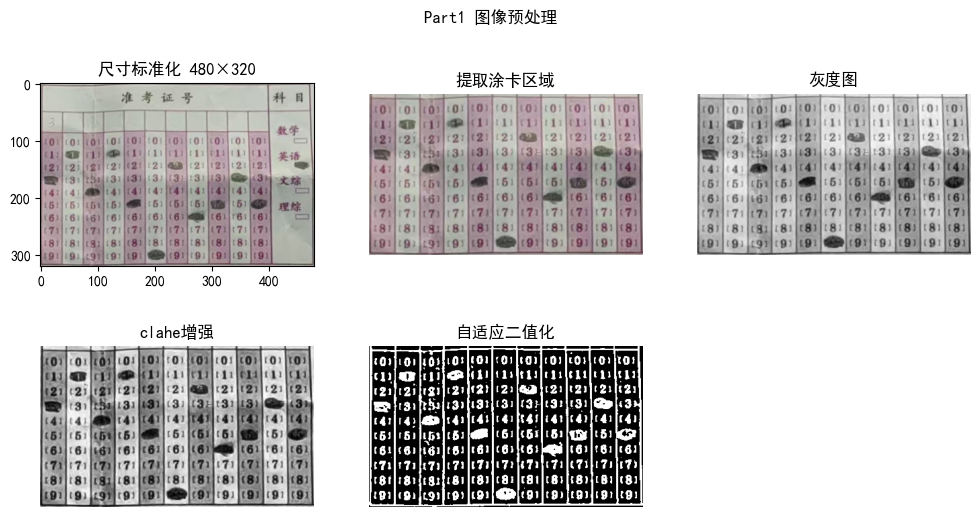

In [3]:
# Step1：尺寸标准化
target_size = (480, 320)
resized = cv2.resize(id_raw, target_size)

# Step2: 提取左下角涂卡区域
roi = resized[int(0.25*target_size[1]):, :int(0.85*target_size[0])]

# Step3: 转灰度图
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Step4：clahe->增强图像对比度
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)

# Step5：自适应二值化
binary = cv2.adaptiveThreshold(gray_enhanced, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 
                                blockSize=31, 
                                C=15)
    
# 绘图
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Part1 图像预处理')

ax1 = plt.subplot(2, 3, 1)
ax1.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
ax1.set_title(f'尺寸标准化 480×320')

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
ax2.set_title('提取涂卡区域')
ax2.set_axis_off()

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(gray, cmap = 'gray')
ax3.set_title('灰度图')
ax3.set_axis_off()

ax4 = plt.subplot(2, 3, 4)
ax4.imshow(gray_enhanced, cmap = 'gray')
ax4.set_title('clahe增强')
ax4.set_axis_off()

ax5 = plt.subplot(2, 3, 5)
ax5.imshow(binary, cmap = 'gray')
ax5.set_title('自适应二值化')
ax5.set_axis_off()



# 检测填涂点位

## 1. 连通域分析

In [4]:
def independent_row_col_clustering(df_points: pd.DataFrame, rows: int, cols: int) -> pd.DataFrame:
    """独立的行列聚类，确保行列号从上到下、从左到右排序"""

    df = df_points.copy()

    # 1. 独立行聚类（对所有y坐标聚类）
    y_coords = df['cy'].values.reshape(-1, 1)
    n_rows = min(rows, len(df))
    
    kmeans_y = KMeans(n_clusters=n_rows, random_state=42, n_init=10)
    df['row_label'] = kmeans_y.fit_predict(y_coords)
    
    # 计算每个聚类标签的y坐标中位数
    row_centers = {}
    for label in df['row_label'].unique():
        row_centers[label] = df[df['row_label'] == label]['cy'].median()
    
    # 按y坐标从小到大排序（从上到下）
    sorted_labels = sorted(row_centers.items(), key=lambda x: x[1])
    
    # 重新分配行号：y坐标最小的为行0，最大的为行9
    row_mapping = {old_label: i for i, (old_label, _) in enumerate(sorted_labels)}
    df['row_id'] = df['row_label'].map(row_mapping)
    
    # 2. 独立列聚类（对所有x坐标聚类）
    x_coords = df['cx'].values.reshape(-1, 1)
    n_cols = min(cols, len(df))
    
    kmeans_x = KMeans(n_clusters=n_cols, random_state=42, n_init=10)
    df['col_label'] = kmeans_x.fit_predict(x_coords)
    
    # 计算每个聚类标签的x坐标中位数
    col_centers = {}
    for label in df['col_label'].unique():
        col_centers[label] = df[df['col_label'] == label]['cx'].median()
    
    # 按x坐标从小到大排序（从左到右）
    sorted_col_labels = sorted(col_centers.items(), key=lambda x: x[1])
    
    # 重新分配列号：x坐标最小的为列0，最大的为列10
    col_mapping = {old_label: i for i, (old_label, _) in enumerate(sorted_col_labels)}
    df['col_id'] = df['col_label'].map(col_mapping)
    
    return df

## 2. 二维点阵去偏

In [5]:
def remove_duplicated_and_outliers(df: pd.DataFrame, 
                                       interval_multiplier: float = 1.8):
    """
    滤除重复点和偏离点
    
    使用numpy和pandas的向量化操作
    """
    if len(df) < 2:
        empty_df = pd.DataFrame(columns=df.columns)
        return df.copy(), empty_df, empty_df
    
    # Step 1: 分离重复点和唯一点
    duplicate_mask = df.duplicated(subset=['row_id', 'col_id'], keep=False)
    df_unique = df[~duplicate_mask].copy()
    df_duplicates = df[duplicate_mask].copy()
    
    if len(df_unique) < 2:
        return df_unique, pd.DataFrame(columns=df.columns), df_duplicates
    
    # Step 2: 快速计算全局间隔
    global_row_interval = _fast_calc_interval(df_unique, 'row_id', 'col_id', 'cx')
    global_col_interval = _fast_calc_interval(df_unique, 'col_id', 'row_id', 'cy')
    
    # Step 3: 快速检测外侧点
    outliers = set()
    
    # 检测行外侧点
    outliers.update(_fast_detect_outliers(df_unique, global_row_interval, 
                                         interval_multiplier, 'row_id', 'col_id', 'cx'))
    
    # 检测列外侧点
    outliers.update(_fast_detect_outliers(df_unique, global_col_interval, 
                                         interval_multiplier, 'col_id', 'row_id', 'cy'))
    
    if outliers:
        df_cleaned = df_unique[~df_unique.index.isin(outliers)].copy()
        df_peripheral_removed = df_unique[df_unique.index.isin(outliers)].copy()
        
        return df_cleaned, df_peripheral_removed, df_duplicates
    
    return df_unique, pd.DataFrame(columns=df.columns), df_duplicates


def _fast_calc_interval(df, group_col, sort_col, coord_col):
    """
    快速计算间隔中位数
    """
    intervals = []
    
    for _, group in df.groupby(group_col):
        if len(group) >= 2:
            # 排序
            sorted_group = group.sort_values(sort_col)
            coords = sorted_group[coord_col].values
            indices = sorted_group[sort_col].values
            
            # 使用numpy广播计算所有点对
            n = len(coords)
            if n > 1:
                # 创建索引矩阵
                i_idx, j_idx = np.triu_indices(n, k=1)
                
                # 计算索引差和坐标差
                index_gaps = indices[j_idx] - indices[i_idx]
                valid_mask = index_gaps > 0
                
                if np.any(valid_mask):
                    coord_gaps = coords[j_idx] - coords[i_idx]
                    unit_intervals = coord_gaps[valid_mask] / index_gaps[valid_mask]
                    intervals.extend(unit_intervals)
    
    return np.median(intervals) if intervals else 0


def _fast_detect_outliers(df, global_interval, multiplier, 
                         group_col, sort_col, coord_col):
    """
    快速检测外侧点
    """
    outliers = set()
    
    for group_id, group in df.groupby(group_col):
        if len(group) < 2:
            continue
            
        # 排序
        sorted_group = group.sort_values(sort_col)
        indices = sorted_group.index.values
        coords = sorted_group[coord_col].values
        sort_vals = sorted_group[sort_col].values
        
        # 检查最左侧点
        leftmost_idx = indices[0]
        for j in range(1, len(sorted_group)):
            index_gap = sort_vals[j] - sort_vals[0]
            if index_gap > 0:
                coord_gap = coords[j] - coords[0]
                expected = global_interval * index_gap
                if coord_gap > expected * multiplier:
                    outliers.add(leftmost_idx)
                break
        
        # 检查最右侧点
        rightmost_idx = indices[-1]
        for j in range(len(sorted_group) - 2, -1, -1):
            index_gap = sort_vals[-1] - sort_vals[j]
            if index_gap > 0:
                coord_gap = coords[-1] - coords[j]
                expected = global_interval * index_gap
                if coord_gap > expected * multiplier:
                    outliers.add(rightmost_idx)
                break
    
    return outliers

## 3、二维网格线性拟合插值

In [6]:
def grid_linear_interpoltate(df_cleaned: pd.DataFrame, n_rows: int = 10, n_cols: int = 11):
    """
    插值填补缺失（漏检/去重）坐标点
    """
    if len(df_cleaned) < 2:
        return df_cleaned.copy(), pd.DataFrame(columns=df_cleaned.columns)
    
    # 准备无争议点的数据
    rows = df_cleaned['row_id'].values.reshape(-1, 1)
    cols = df_cleaned['col_id'].values.reshape(-1, 1)
    xs = df_cleaned['cx'].values
    ys = df_cleaned['cy'].values
    
    # 创建特征矩阵
    X_features = np.hstack([rows, cols, rows * cols])
    
    # 拟合x和y坐标的线性模型
    model_x = LinearRegression()
    model_y = LinearRegression()
    model_x.fit(X_features, xs)
    model_y.fit(X_features, ys)
    
    # 将df_cleaned转换为字典
    clean_dict = {}
    for idx, row in df_cleaned.iterrows():
        key = (int(row['row_id']), int(row['col_id']))
        clean_dict[key] = row
    
    # 计算平均的宽高
    avg_w = df_cleaned['w'].mean() if len(df_cleaned) > 0 else 10
    avg_h = df_cleaned['h'].mean() if len(df_cleaned) > 0 else 10
    avg_area = df_cleaned['area'].mean() if len(df_cleaned) > 0 else 100
    
    # 处理每个网格位置
    complete_points = []
    interpolated_points = []
    
    for row in range(n_rows):
        for col in range(n_cols):
            key = (row, col)
            
            # 预测理论值
            X_test = np.array([[row, col, row * col]])
            x_theory = model_x.predict(X_test)[0]
            y_theory = model_y.predict(X_test)[0]
            
            if key in clean_dict:
                point = clean_dict[key].to_dict()
                point['interpolated'] = False
                complete_points.append(point)
            else:
                interp_point = {
                    'row_id': row,
                    'col_id': col,
                    'cx': x_theory,
                    'cy': y_theory,
                    'x': x_theory - avg_w/2,
                    'y': y_theory - avg_h/2,
                    'w': avg_w,
                    'h': avg_h,
                    'area': avg_area,
                    'interpolated': True
                }
                complete_points.append(interp_point)
                interpolated_points.append(interp_point)
    
    # 转换为DataFrame
    df_complete = pd.DataFrame(complete_points)
    df_interpolated = pd.DataFrame(interpolated_points)
    
    return df_complete, df_interpolated

## 主程序

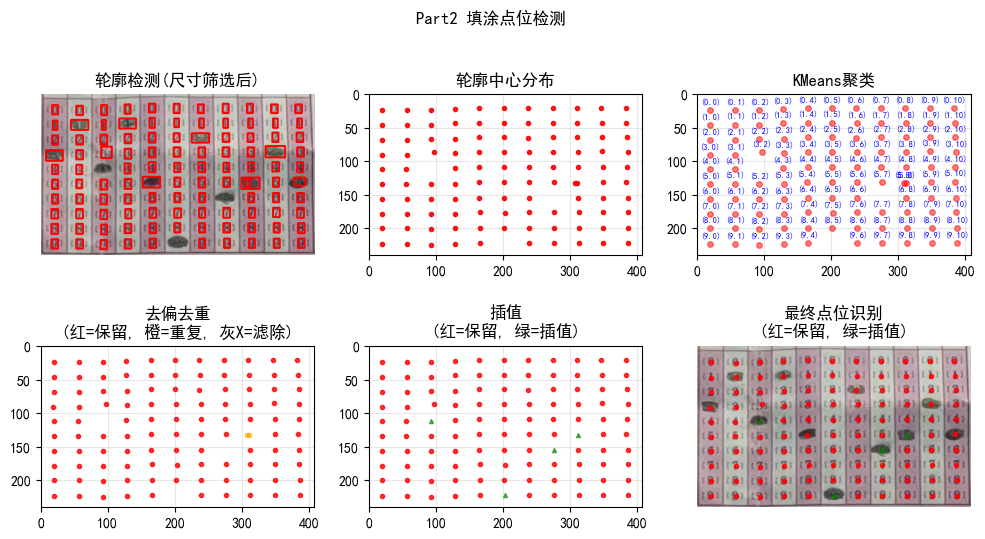

In [ ]:
# Step6: 提取轮廓 + 尺寸筛选
cnts, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
points = []
for c in cnts:
    area = cv2.contourArea(c)
    x, y, w_rect, h_rect = cv2.boundingRect(c)   
    if (35 < area < 600 and 
        0.2 < w_rect/h_rect < 5 and 
        5 < h_rect < 50 and 
        2 < w_rect < 30):

        cx = x + w_rect // 2
        cy = y + h_rect // 2
        points.append({
            'x': x, 'y': y, 'w': w_rect, 'h': h_rect,
            'cx': cx, 'cy': cy, 
            'area': area,
        })       
df_points = pd.DataFrame(points)

# Step7: Kmeans行列聚类
df_independent = independent_row_col_clustering(df_points.copy(), rows = 10, cols = 11)

# Step8: 过滤离群点和重复点                   
df_cleaned, df_peripheral_removed, df_duplicates = remove_duplicated_and_outliers(df_independent, interval_multiplier=1.8)

# Step9: 插值填补缺失点
df_complete, df_interpolated = grid_linear_interpoltate(df_cleaned, n_rows=10, n_cols=11)

# 绘图
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Part2 填涂点位检测')

ax1 = plt.subplot(2, 3, 1)
contour_img = cv2.cvtColor(roi.copy(), cv2.COLOR_BGR2RGB) 
for _, point in df_points.iterrows():
    cv2.rectangle(contour_img, (int(point['x']), int(point['y'])), 
                    (int(point['x']+point['w']), int(point['y']+point['h'])), 
                    (255, 0, 0), 2)
ax1.imshow(contour_img)
ax1.set_title(f'轮廓检测(尺寸筛选后)')
ax1.set_axis_off()

ax2 = plt.subplot(2, 3, 2)
ax2.set_xlim(0, roi.shape[1]) 
ax2.set_ylim(roi.shape[0], 0) 
ax2.set_aspect('equal')  # 保持纵横比
for _, point in df_points.iterrows():
    ax2.plot(point['cx'], point['cy'], 'ro', markersize=3, alpha=0.9)
ax2.set_title('轮廓中心分布')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
ax3.set_xlim(0, roi.shape[1])
ax3.set_ylim(roi.shape[0], 0)
ax3.set_aspect('equal')
for idx, row in df_independent.iterrows():
    ax3.plot(row['cx'], row['cy'], 'ro', markersize=4, alpha=0.5)
    label = f"({int(row['row_id'])}.{int(row['col_id'])})"
    ax3.text(row['cx'], row['cy']-6, label, 
             color='blue', fontsize=6, ha='center', va='bottom')
ax3.set_title('KMeans聚类')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
ax4.set_xlim(0, roi.shape[1])
ax4.set_ylim(roi.shape[0], 0)
ax4.set_aspect('equal')
for idx, row in df_duplicates.iterrows():
    ax4.plot(row['cx'], row['cy'], 'o', 
             color='orange', markersize=3, alpha=0.6, markerfacecolor='orange')
for idx, row in df_peripheral_removed.iterrows():
    ax4.plot(row['cx'], row['cy'], 'x', 
             color='gray', markersize=5, alpha=0.8, mew=1.5)
for idx, row in df_cleaned.iterrows():
    ax4.plot(row['cx'], row['cy'], 'ro', markersize=3, alpha=0.8)
ax4.set_title('去偏去重\n(红=保留, 橙=重复, 灰X=滤除)')
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(2, 3, 5)

ax5.set_xlim(0, roi.shape[1])
ax5.set_ylim(roi.shape[0], 0)
ax5.set_aspect('equal')
for idx, row in df_interpolated.iterrows():
    ax5.plot(row['cx'], row['cy'], '^', 
             color='green', markersize=3, alpha=0.6, markerfacecolor='green')
for idx, row in df_cleaned.iterrows():
    ax5.plot(row['cx'], row['cy'], 'ro', markersize=3, alpha=0.8)
ax5.set_title('插值\n(红=保留, 绿=插值)')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(2, 3, 6)
ax6.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
for idx, row in df_cleaned.iterrows():
    ax6.plot(row['cx'], row['cy'], 'ro', markersize=3, alpha=0.8)
    label = f"({int(row['row_id'])}.{int(row['col_id'])})"
for idx, row in df_interpolated.iterrows():
    ax6.plot(row['cx'], row['cy'], 'g^', markersize=3, alpha=0.8)
    label = f"({int(row['row_id'])}.{int(row['col_id'])})"
ax6.set_title('最终点位识别\n(红=保留, 绿=插值)')
ax6.set_axis_off()


# 检测点位填涂情况

## 1、从填涂结果识别学号

In [8]:
def _recognize_student_id(df: pd.DataFrame) -> str:
    """从填涂结果识别学号"""
    if 'row_id' not in df.columns or 'col_id' not in df.columns:
        return ""
    
    # 获取列数范围
    cols = sorted(df['col_id'].unique())
    
    student_id = ""
    
    for col in cols:
        # 获取该列的所有点
        col_points = df[df['col_id'] == col]
        
        # 查找填涂的点
        filled_points = col_points[col_points['is_filled']]
        
        if len(filled_points) == 1:
            # 只有一个填涂点，取其行号
            row_id = int(filled_points.iloc[0]['row_id'])
            student_id += str(row_id)
        elif len(filled_points) > 1:
            # 多个填涂点，取填涂比例最高的
            best_idx = filled_points['fill_ratio'].idxmax()
            row_id = int(filled_points.loc[best_idx, 'row_id'])
            student_id += str(row_id)
        else:
            # 没有填涂点
            student_id += "?"
    
    return student_id

## 2、 检测点位是否填涂

In [9]:
def detect_filling(df_grid: pd.DataFrame, image: np.ndarray, roi_size, fill_threshold) -> pd.DataFrame:
    """检测每个网格点是否填涂"""
    df = df_grid.copy()
    
    if df.empty:
        return df
    
    # 初始化填涂相关列
    df['fill_ratio'] = 0.0
    df['is_filled'] = False
    df['fill_type'] = 'unknown'
    
    # 获取ROI大小
    roi_w, roi_h = roi_size
    threshold = fill_threshold
    
    for idx, row in df.iterrows():
        # 计算ROI边界
        x1 = int(row['cx'] - roi_w // 2)
        y1 = int(row['cy'] - roi_h // 2)
        x2 = int(row['cx'] + roi_w // 2)
        y2 = int(row['cy'] + roi_h // 2)
        
        # 确保ROI在图像范围内
        h, w = image.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        if x2 > x1 and y2 > y1:
            roi = image[y1:y2, x1:x2]
            if roi.size > 0:
                # 计算白色像素占比
                total_pixels = roi.size
                white_pixels = cv2.countNonZero(roi)
                fill_ratio = white_pixels / total_pixels
                
                df.at[idx, 'fill_ratio'] = fill_ratio
                
                # 判断是否填涂
                is_filled = fill_ratio > threshold
                df.at[idx, 'is_filled'] = is_filled
    
    # 识别学号
    student_id = _recognize_student_id(df)
    
    return student_id, df

## 主程序

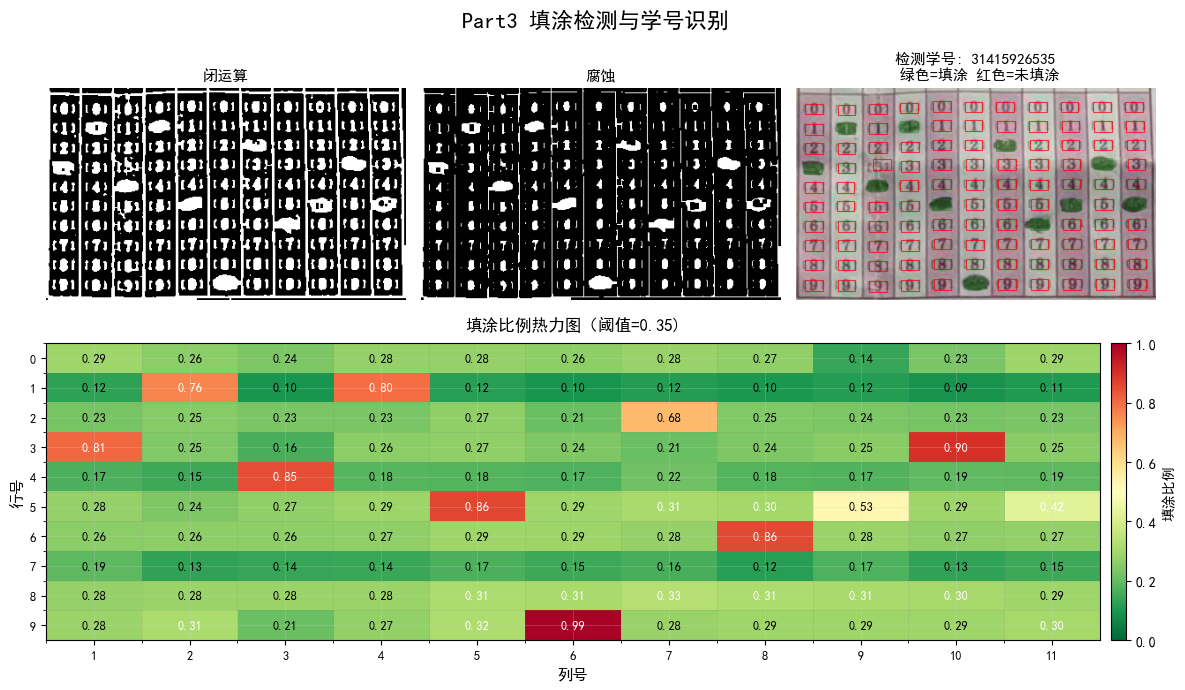

In [10]:
# Step10: 闭运算，强化填涂块与未填涂数字差异
kernel_closed = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_closed)

# Step11: 腐蚀二值化图像，强化填涂块与未填涂数字差异
kernel_eroded = np.ones((3, 3), np.uint8)
eroded = cv2.erode(closed, kernel_eroded, iterations=1)

# Step12: 检测各点位填涂情况
roi_w, roi_h = 20, 12
fill_threshold = 0.35
student_id, df_result = detect_filling(df_complete, eroded, roi_size=(roi_w, roi_h), fill_threshold=fill_threshold)

# 绘图 
fig = plt.figure(figsize=(12, 7))
plt.suptitle('Part3 填涂检测与学号识别', fontsize=16, y=0.98)

# 第一行：三个子图
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(closed, cmap='gray')
ax1.set_title('闭运算', fontsize=11)
ax1.set_axis_off()

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(eroded, cmap='gray')
ax2.set_title('腐蚀', fontsize=11)
ax2.set_axis_off()

ax3 = plt.subplot(2, 3, 3)
roi_display = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
ax3.imshow(roi_display)
for idx, row in df_result.iterrows():
    x1 = int(row['cx'] - roi_w // 2)
    y1 = int(row['cy'] - roi_h // 2)
    if row['is_filled']:
        rect = plt.Rectangle((x1, y1), roi_w, roi_h, 
                             fill=True, edgecolor='green', 
                             facecolor='green', alpha=0.3, linewidth=0.8)
    else:
        rect = plt.Rectangle((x1, y1), roi_w, roi_h, 
                             fill=False, edgecolor='red', 
                             linewidth=0.8, alpha=0.7)
    ax3.add_patch(rect)
ax3.set_title(f'检测学号: {student_id}\n 绿色=填涂 红色=未填涂', fontsize=11)
ax3.set_axis_off()

# 第二行：热力图占据三列
ax4 = plt.subplot(2, 1, 2)

# 创建热力图
heatmap_data = np.zeros((10, 11))
for idx, row in df_result.iterrows():
    row_id = int(row['row_id'])
    col_id = int(row['col_id'])
    if 0 <= row_id < 10 and 0 <= col_id < 11:
        heatmap_data[row_id, col_id] = row['fill_ratio']

# 绘制热力图
im = ax4.imshow(heatmap_data, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)

# 颜色条
cbar = plt.colorbar(im, ax=ax4, fraction=0.04, pad=0.01)
cbar.set_label('填涂比例', fontsize=10)

# 设置坐标轴
ax4.set_xticks(range(11))
ax4.set_yticks(range(10))
ax4.set_xticklabels(range(1, 12), fontsize=9)
ax4.set_yticklabels(range(10), fontsize=9)
ax4.set_xlabel('列号', fontsize=11)
ax4.set_ylabel('行号', fontsize=11)

# 智能文本颜色
for i in range(10):
    for j in range(11):
        value = heatmap_data[i, j]
        # 更智能的颜色选择
        if value > 0.7:
            text_color = 'white'
        elif value < 0.3:
            text_color = 'black'
        else:
            # 使用HSV亮度计算
            text_color = 'white' if value < 0.5 else 'black'
        
        text = f'{value:.2f}'
        ax4.text(j, i, text, 
                 ha='center', va='center', 
                 color=text_color, fontsize=9, 
                 fontweight='bold' if value > fill_threshold else 'normal')

ax4.set_title(f'填涂比例热力图（阈值={fill_threshold})', fontsize=12, pad=10)

# 添加网格
ax4.grid(which="both", color="lightgray", linestyle='-', linewidth=0.5, alpha=0.3)
ax4.set_xticks(np.arange(-0.5, 10.5, 1), minor=True)
ax4.set_yticks(np.arange(-0.5, 9.5, 1), minor=True)
ax4.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.2)

plt.tight_layout()
plt.show()
